<a href="https://colab.research.google.com/github/gkv856/util_repo/blob/master/cGAN_pix2pix_CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cGAN using pix2pix


## Importing the libraries

### Installing torchviz to Visualize the model flow

In [101]:
!pip install torchviz

In [102]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os

In [103]:
torch.__version__

'2.0.1+cu118'

## Downloading the dataset

Other Available datasets:
* `cityscapes`
* `edges2handbags`
* `edges2shoes`
* `facades`
* `night2day`

(https://github.com/affinelayer/pix2pix-tensorflow#datasets-and-trained-models)

In [104]:
dataset = 'maps'

In [105]:
dataset_file = "{}.tar.gz".format(dataset)
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(dataset_file)
print(dataset_url)

http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz


In [106]:
import urllib.request
import zipfile
import os

# Specify the download directory
download_dir = "./data"

# Create the download directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Determine the default file name from the URL
file_name = os.path.basename(dataset_url)

# Construct the full file path
file_path = os.path.join(download_dir, file_name)

# Download the dataset if it hasn't been downloaded yet
if not os.path.exists(file_path):
    urllib.request.urlretrieve(dataset_url, file_path)

# Verify if the downloaded file is a valid zip archive
if zipfile.is_zipfile(file_path):
    # Extract the zip file
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(download_dir)
else:
    print(f"The downloaded file '{file_path}' is not a valid zip archive.")

The downloaded file './data/maps.tar.gz' is not a valid zip archive.


In [107]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [108]:
import tarfile

# Open the tar.gz file and extract its contents
with tarfile.open("/content/data/maps.tar.gz", 'r:gz') as tar:
    tar.extractall("/content/data/imgs/")

In [109]:
H, W = 256, 512

## Function to display Original and Transformed Images side-by-side

In [110]:
def showImgPair(ds_data):
  img1, img2 = ds_data[0], ds_data[1]

  img1, img2 = img1.cpu(), img2.cpu()

  print(img1.shape, img2.shape)
  print("Original min, max, mean", img1.min(), img1.max(), img1.mean(), img1.std())
  print("Transformed min, max, mean", img2.min(), img2.max(), img2.mean(), img2.std())
  fig, axs = plt.subplots(1, 2)
  # Plot the first image in the first subplot
  axs[0].imshow(img1.permute(1, 2, 0).detach().numpy())
  axs[0].set_title('Original Image')

  # Plot the second image in the second subplot
  axs[1].imshow(img2.permute(1, 2, 0).detach().numpy() )
  axs[1].set_title('Transformed Image')

  # Adjust spacing between subplots
  plt.tight_layout()

  # Display the figure
  plt.show()

## Dataset class to transform the image to desired dimensions

In [111]:
from torch.utils.data import Dataset
from PIL import Image

class Pix2PixDataset(Dataset):
  def __init__(self, root_dir, max_jitter=32, H=256, W=512):
    self.root_dir = root_dir
    self.transforms = [T.Resize((H, W)), T.ToTensor()]
    self.files = os.listdir(self.root_dir)
    self.H, self.W = H, W

    self.mean_img1, self.std_img1 = 0.23762472442276503, 0.124095955047838
    self.mean_img2, self.std_img2 = 0.8786841903398507, 0.08264635288815973

    self.transforms = T.Compose([
            T.ToPILImage(),
            T.RandomCrop(H-10),
            # T.RandomHorizontalFlip(),
            # T.RandomVerticalFlip(),
            T.Resize((H, H)),
            T.ToTensor(),
            # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])


  def __len__(self):
    return len(self.files)  #190 for train set

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.files[index])
    image = Image.open(img_path)

    # Step 1: Resize the image to 256x512
    resize_transform = T.Compose([
        T.Resize((self.H, self.W)),
        T.ToTensor()
    ])

    resized_image = resize_transform(image)

    # Step 2: Split the image into two parts
    H = 256  # Assuming you want to split it in half vertically
    ori_img = resized_image[:, :, :H]
    tfm_img = resized_image[:, :, H:]

    ori_img = self.transforms(ori_img)
    tfm_img = self.transforms(tfm_img)



    return ori_img , tfm_img



### Creating Train and Test Datasets

In [112]:
max_jitter  = 32.
ds_train = Pix2PixDataset("/content/data/imgs/maps/train")
ds_test = Pix2PixDataset("/content/data/imgs/maps/val")

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
Original min, max, mean tensor(0.0118) tensor(0.7961) tensor(0.1859) tensor(0.1051)
Transformed min, max, mean tensor(0.5961) tensor(1.) tensor(0.8401) tensor(0.1138)


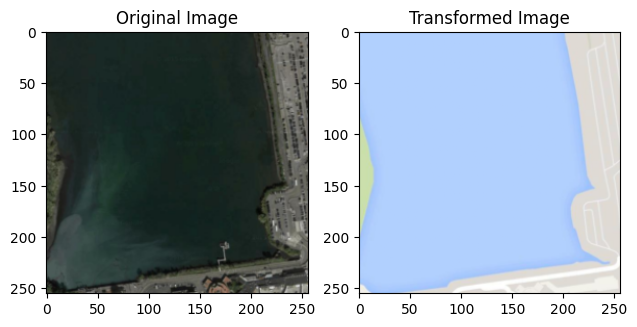

In [113]:
idx = 12
data = ds_train[idx]
showImgPair(data)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
Original min, max, mean tensor(0.0196) tensor(0.9843) tensor(0.2453) tensor(0.1160)
Transformed min, max, mean tensor(0.3333) tensor(1.) tensor(0.9081) tensor(0.0736)


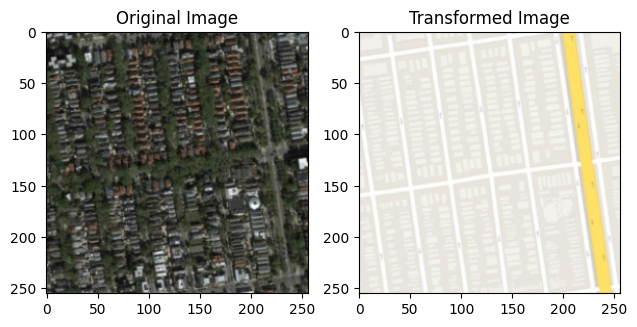

In [114]:
idx = 12
data = ds_test[idx]
showImgPair(data)

## Setting the Hyper-Parameters

In [115]:
BS = 1 # batch-size
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

## Creating Train Loader to get Batch of images

In [116]:
# Create data loaders to efficiently load the data in batches
train_loader = torch.utils.data.DataLoader(dataset=ds_train, batch_size=BS, shuffle=True)

# Create data loaders to efficiently load the data in batches
test_loader = torch.utils.data.DataLoader(dataset=ds_test, batch_size=BS, shuffle=False)

### Setting up the device type

In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Testing the train and test loader

In [118]:
for img_ori, img_tfm in test_loader:
  print(img_ori.shape, img_tfm.shape, img_ori[0].min(), img_ori[0].max())
  break

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256]) tensor(0.0392) tensor(0.9922)


In [119]:
for img_oriT, img_tfmT in test_loader:
  print(img_oriT.shape, img_tfmT.shape, img_oriT[0].min(), img_oriT[0].max())
  break

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256]) tensor(0.0392) tensor(0.9922)


## Aux Model Modules

### Creating Encoder Block

In [120]:
import torch
import torch.nn as nn
import torch.nn.init as init


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, apply_batchnorm=True):
        super(EncoderBlock, self).__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.apply_batchnorm = apply_batchnorm

        # Initialize weights with mean=0 and std=0.02
        init.normal_(self.conv2d.weight, mean=0.0, std=0.02)

        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv2d(x)
        if self.apply_batchnorm:
            x = self.batchnorm(x)
        x = self.leaky_relu(x)
        return x



### Testing Encoder Block

In [121]:
down_sample = EncoderBlock(3, 64, 4, True)
down_sample = down_sample.to(device)
img_ori = img_ori.to(device)
down_sample_result = down_sample(img_ori)
down_sample_result.shape

torch.Size([1, 64, 128, 128])

### Creating Decoder Block

In [122]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, apply_dropout=False):
        super(DecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, output_padding=0, bias=False)
        # Initialize weights with mean=0 and std=0.02
        nn.init.normal_(self.conv_transpose.weight, mean=0.0, std=0.02)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.apply_dropout = apply_dropout
        if apply_dropout:
            self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv_transpose(x)
        x = self.batchnorm(x)
        if self.apply_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        return x

def decode(in_f, out_f, ks, apply_dropout=False):
    decoder_block = DecoderBlock(in_f, out_f, ks, apply_dropout)
    return decoder_block


### Testing Decoder Block

In [123]:
up_model = decode(64, 3, 4).to(device)
up_sample_result = up_model(down_sample_result)
print(up_sample_result.shape)

torch.Size([1, 3, 256, 256])


torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
Original min, max, mean tensor(0.0392) tensor(0.9922) tensor(0.3612) tensor(0.1739)
Transformed min, max, mean tensor(0., grad_fn=<MinBackward1>) tensor(5.2821, grad_fn=<MaxBackward1>) tensor(0.3814, grad_fn=<MeanBackward0>) tensor(0.5609, grad_fn=<StdBackward0>)


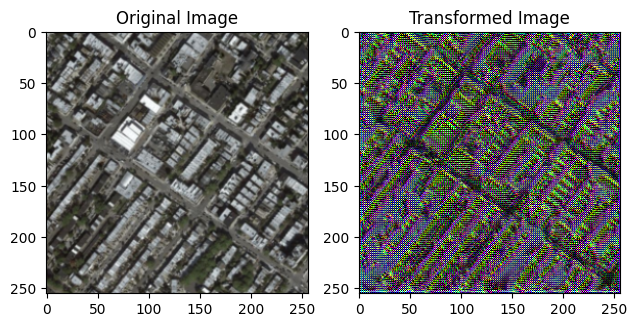

In [124]:
showImgPair((img_ori[0], up_sample_result[0]))

## Generator Model

### Designing Generator Model

In [125]:
"""
Generator Neural Network Module

This module defines a Generator neural network class for image generation using a U-Net architecture.
The network comprises a series of downsampling and upsampling blocks, with skip connections to
capture details at multiple scales. It takes an input tensor and produces an output tensor of the
specified number of output channels.

"""

class Generator(nn.Module):
    def __init__(self):
        """
        Initialize the Generator network.

        The Generator consists of downsampling and upsampling layers that form a U-Net architecture.
        It is designed for image-to-image translation tasks.

        """
        super(Generator, self).__init__()


        # Downsampling layers
        self.downsampling = nn.ModuleList([
            EncoderBlock(3, 64, 4, False),  # (batch_size, 128, 128, 64)
            EncoderBlock(64, 128, 4),  # (batch_size, 64, 64, 128)
            EncoderBlock(128, 256, 4),  # (batch_size, 32, 32, 256)
            EncoderBlock(256, 512, 4),  # (batch_size, 16, 16, 512)
            EncoderBlock(512, 512, 4),  # (batch_size, 8, 8, 512)
            EncoderBlock(512, 512, 4),  # (batch_size, 4, 4, 512)
            EncoderBlock(512, 512, 4),  # (batch_size, 2, 2, 512)
            EncoderBlock(512, 512, 4, False),  # (batch_size, 1, 1, 512)
        ])

        # Upsampling layers
        self.upsampling = nn.ModuleList([
            DecoderBlock(512, 512, 4, apply_dropout=True),  # (batch_size, 2, 2, 512)
            DecoderBlock(1024, 512, 4, apply_dropout=True),  # (batch_size, 4, 4, 512)
            DecoderBlock(1024, 512, 4, apply_dropout=True),  # (batch_size, 8, 8, 512)
            DecoderBlock(1024, 512, 4),  # (batch_size, 16, 16, 512)
            DecoderBlock(1024, 256, 4),  # (batch_size, 32, 32, 256)
            DecoderBlock(512, 128, 4),  # (batch_size, 64, 64, 128)
            DecoderBlock(256, 64, 4),  # (batch_size, 128, 128, 64)
        ])

        # Final output layer
        self.last = nn.ConvTranspose2d(128, 3,
                                       kernel_size=4,
                                       stride=2,
                                       padding=1,
                                       bias=False)

        nn.init.normal_(self.last.weight, mean=0.0, std=0.02)
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Forward pass of the Generator network.

        Args:
            x (torch.Tensor): Input tensor, typically an image.

        Returns:
            torch.Tensor: Output tensor representing the generated image.

        """
        skips = []

        # Downsampling path
        for down in self.downsampling:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # # Upsampling path
        for up, skip in zip(self.upsampling, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)  # Concatenate along the channel dimension


        x = self.last(x)
        x = self.tanh(x)

        return x


### Test & Visualize Generator model

torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
Original min, max, mean tensor(0.0392) tensor(0.9922) tensor(0.3612) tensor(0.1739)
Transformed min, max, mean tensor(-0.8865, grad_fn=<MinBackward1>) tensor(0.8527, grad_fn=<MaxBackward1>) tensor(-0.0163, grad_fn=<MeanBackward0>) tensor(0.1864, grad_fn=<StdBackward0>)


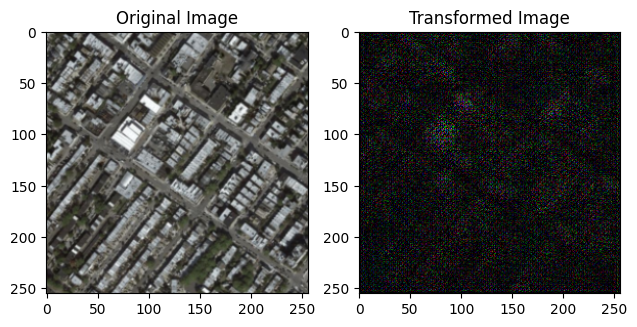

In [126]:
# Instantiate your generator model
test_netG = Generator()
test_netG = test_netG.to(device)
# Create a dummy input tensor with the desired shape (batch_size, channels, height, width)
img_ori = img_ori.to(device)

# test_netG.eval()

test_netG_result = test_netG(img_ori)

print(test_netG_result.shape)

# looking at untrained generator input and result
showImgPair((img_ori[0], test_netG_result[0]))

### Summary of Generator Model

In [127]:
from torchsummary import summary

summary(test_netG, input_size=(img_ori[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
      EncoderBlock-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         LeakyReLU-6          [-1, 128, 64, 64]               0
      EncoderBlock-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        LeakyReLU-10          [-1, 256, 32, 32]               0
     EncoderBlock-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
        LeakyReLU-14          [-1, 512,

In [128]:
from torchviz import make_dot
import cv2

# Create a visualization of the computation graph
dot = make_dot(test_netG_result, params=dict(test_netG.named_parameters()))

# Save the graph as an image or display it
path_test_netG = dot.render("path_test_netG_graph", format="png")


In [129]:
def showNetworkGraph(path):
  img = cv2.imread(path)
  # Set the figure size and display the image
  plt.figure(figsize=(90, 90))  # Adjust the figure size as needed
  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels
  plt.show()


### Graph Visualization for Generator Model

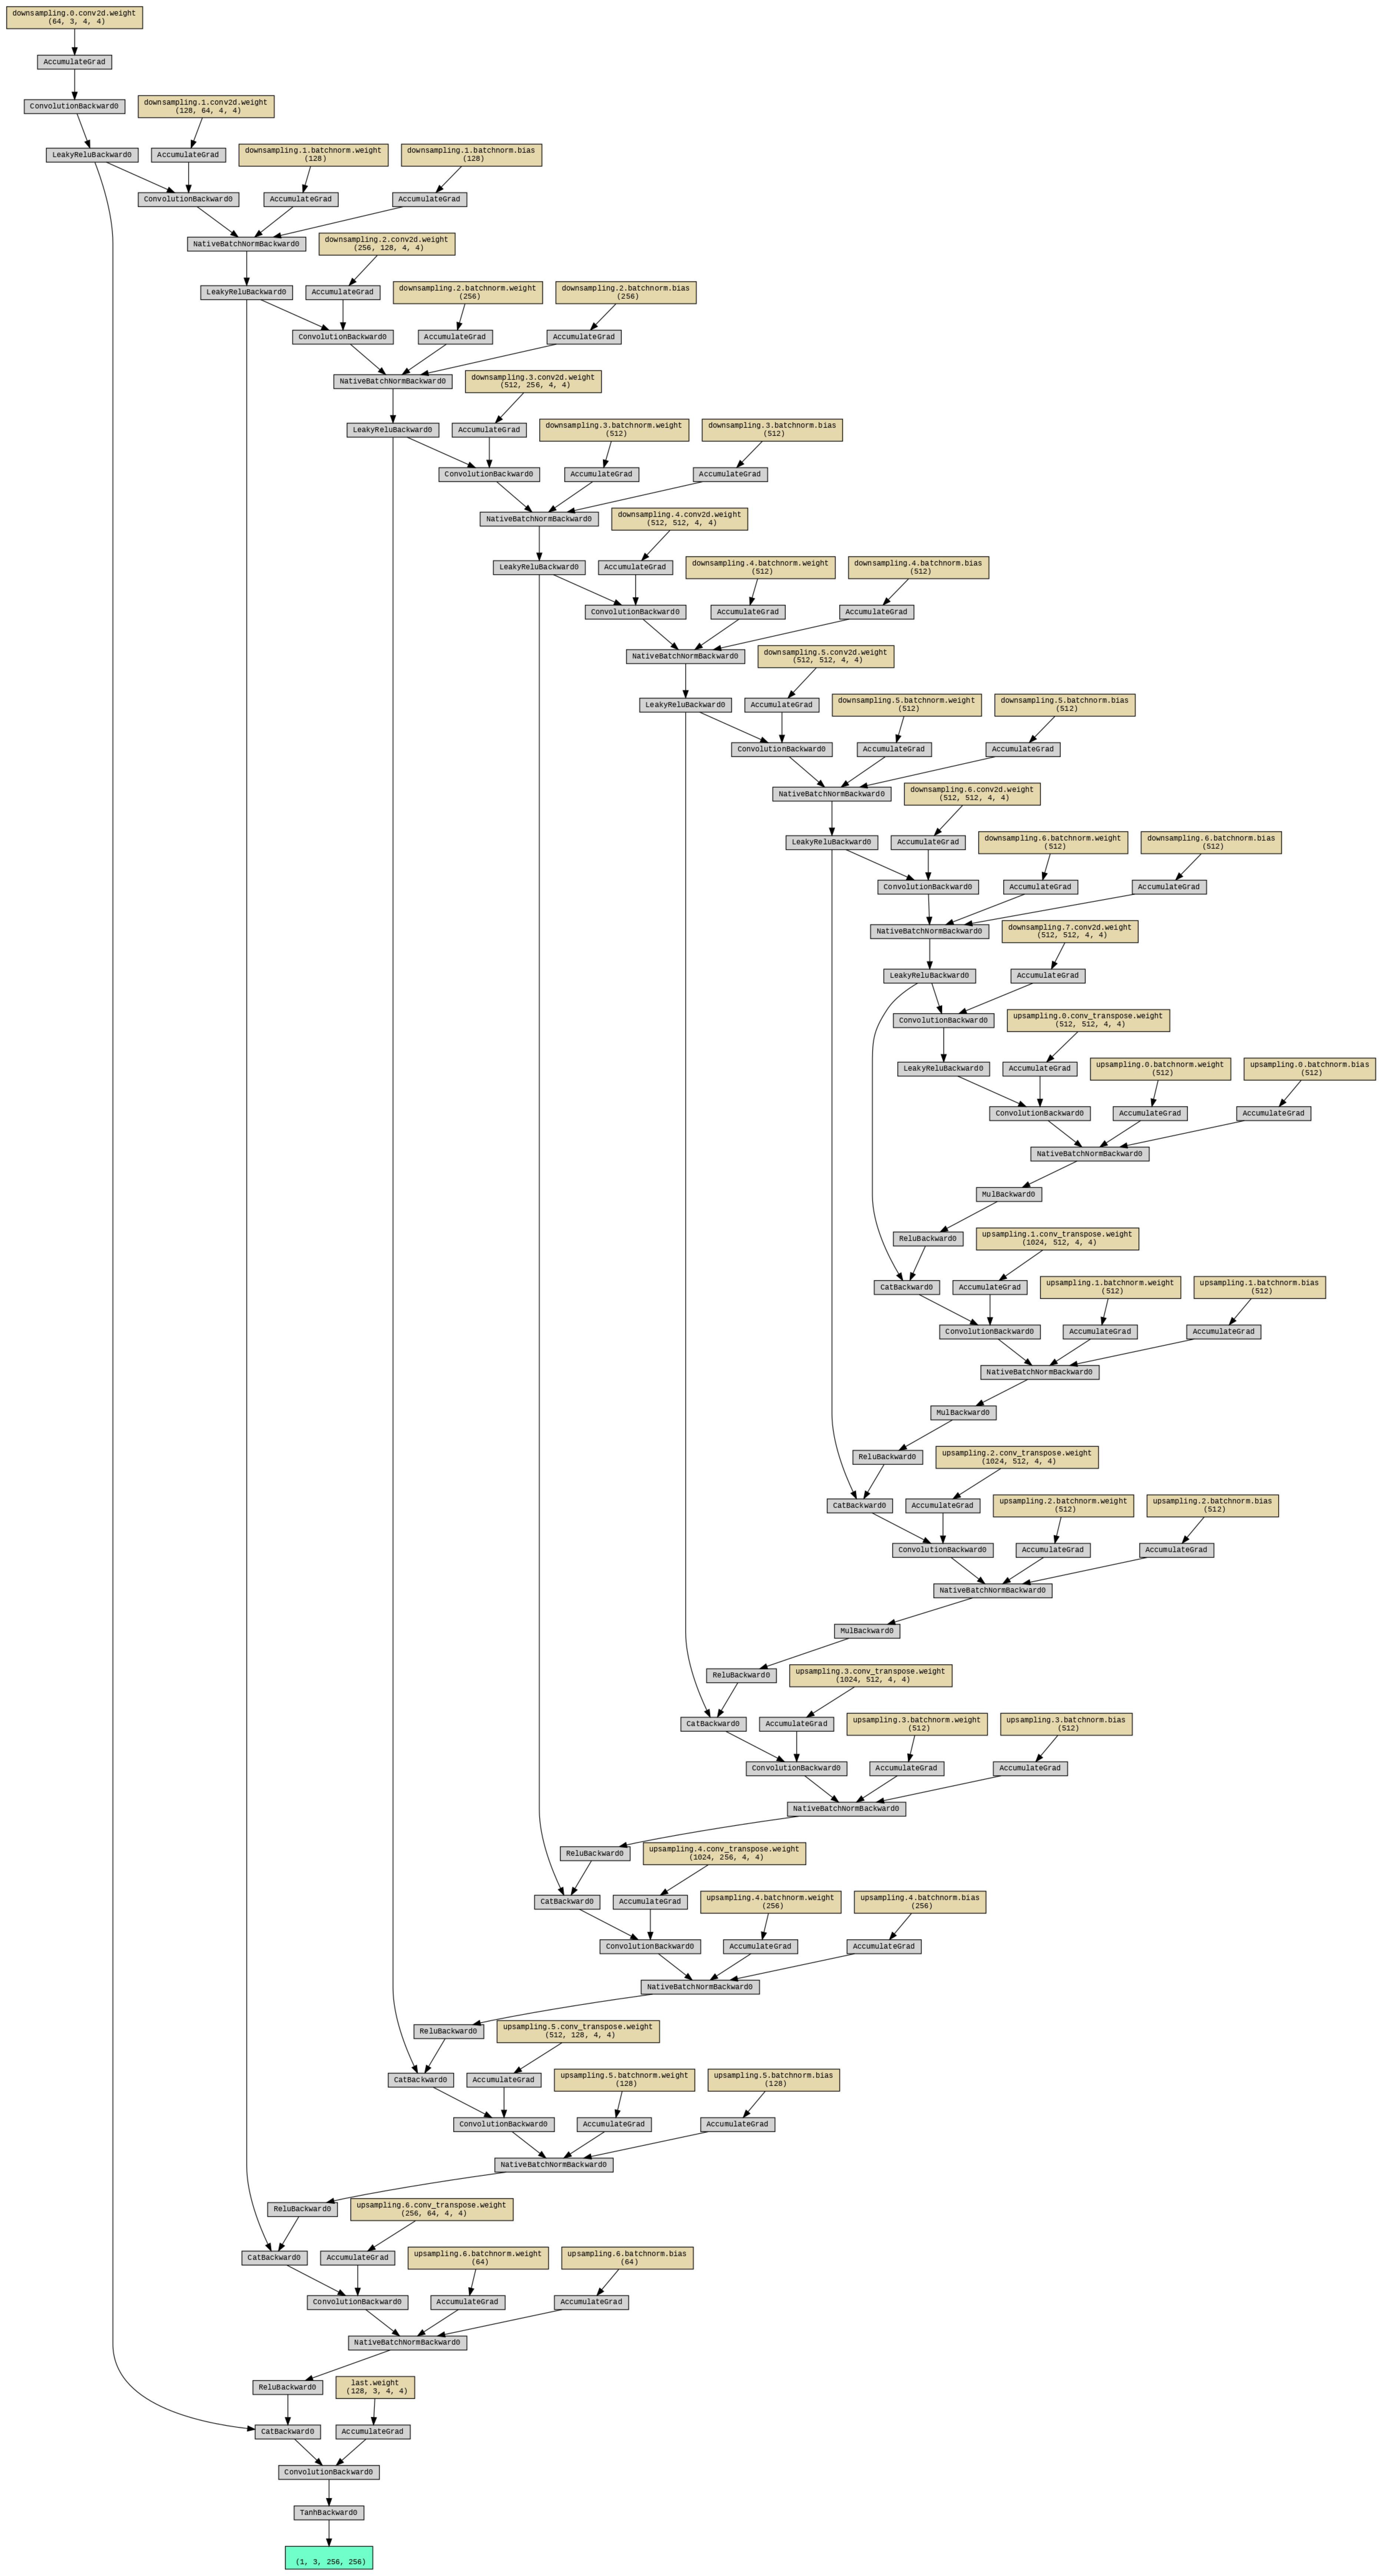

In [130]:
showNetworkGraph(path_test_netG)

### Generator loss

Normal GANs learn loss that adapts to the data, while cGAN learns structured loss that penalizes a possible structure that differs from the network output and the expected "real" image. More details: https://arxiv.org/abs/1611.07004


> **Hyperparameters**

Default values suggested in the paper

* Learning rate: 0.0002
* Momentum: [β1, β2] = [0.5, 0.999]
* Lambda (λ_L1) = 100

* The generator loss is a cross-entropy sigmoid of the generated images and an array of 1's
* The pix2pix paper also mentions L1 loss, which is a MAE (Mean Absolute Error) between the generated image and the expected (real) one. This ensures that the generated image becomes structurally similar to the real image.
* The equation for calculating the total loss is gan_loss + LAMBDA * l1_loss where LAMBDA = 100 - this value is also described by the authors of the paper.

In [131]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

In [132]:
"""
Generator Loss Function for Adversarial and L1 Loss

This module defines a custom generator loss function for training generative adversarial networks (GANs).
The loss consists of two components: a GAN loss (Binary Cross-Entropy) and an L1 loss (Mean Absolute Error).
These components are combined to compute the total generator loss.

"""

# Define the Binary Cross-Entropy Loss
criterionG = nn.BCEWithLogitsLoss()


def loss_netG(netD_output, netG_output, target, lambda_=100):
    """
    Compute the generator loss for GAN training.

    Args:
        netD_output (torch.Tensor): Discriminator's output for generated data.
        netG_output (torch.Tensor): Generator's output, representing generated data.
        target (torch.Tensor): Target data that the generator is trying to approximate.
        lambda_ (float, optional): Weighting factor for the L1 loss. Default is 100.

    Returns:
        tuple of torch.Tensor: A tuple containing the following elements:
            - g_loss_total (torch.Tensor): Total generator loss.
            - gan_loss (torch.Tensor): GAN loss (Binary Cross-Entropy).
            - l1_loss (torch.Tensor): L1 loss (Mean Absolute Error).

    """
    # Calculate the GAN loss (Binary Cross-Entropy)
    t_ones = torch.ones_like(netD_output)
    gan_loss = criterionG(t_ones, netD_output)

    # Calculate the L1 loss (Mean Absolute Error)
    l1_loss = torch.mean(torch.abs(target - netG_output))

    # Calculate the total generator loss by combining GAN and L1 losses
    g_loss_total = gan_loss + (lambda_ * l1_loss)

    return g_loss_total, gan_loss, l1_loss

# Example usage:
# total_loss, gan_loss, l1_loss = generator_loss(discriminator_output, generator_output, target_data)

## Discriminator Model

The discriminator is a [PatchGAN](https://paperswithcode.com/method/patchgan). The goal is to classify if each patch (piece) of the image is real or fake.

* Blocks of the discriminator: Convolution -> Batch normalization -> Leaky ReLU.

* The output shape is `(batch_size, 30, 30, 1)`

More information: https://arxiv.org/abs/1611.07004

The discriminator receives two inputs:
  1. The input image and the expected image, which should be classified as real
  2. The input image and the generated image (fake, generated by the generator), which should be classified as fake.

### Designing Discriminator Model

In [133]:
"""
Discriminator Neural Network Module

This module defines a Discriminator neural network class for use in adversarial training, often in the context of
a Generative Adversarial Network (GAN). The Discriminator is responsible for distinguishing between real and
generated data by processing input tensors and making a binary classification.

"""


class Discriminator(nn.Module):
    def __init__(self):
        """
        Initialize the Discriminator network.

        The Discriminator is designed for binary classification and consists of encoding layers, zero-padding,
        and convolutional layers with batch normalization and activation functions.

        """
        super(Discriminator, self).__init__()

        # Initializer
        initializer = nn.init.normal_

        # Encoding layers
        self.down1 = EncoderBlock(6, 64, 4, False)
        self.down2 = EncoderBlock(64, 128, 4)
        self.down3 = EncoderBlock(128, 256, 4)

        # Zero-padding and convolutional layers
        self.zero_pad1 = nn.ZeroPad2d((1, 1, 1, 1))
        self.conv1 = nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0, bias=False)
        initializer(self.conv1.weight, 0., 0.02)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.leaky_relu = nn.LeakyReLU(0.2)

        self.zero_pad2 = nn.ZeroPad2d((1, 1, 1, 1))
        self.conv2 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)
        initializer(self.conv2.weight, 0., 0.02)

    def forward(self, inputs):
        """
        Forward pass of the Discriminator network.

        Args:
            original (torch.Tensor): Input tensor representing original data.
            transformed (torch.Tensor): Input tensor representing transformed or generated data.

        Returns:
            torch.Tensor: Output tensor representing the Discriminator's binary classification result.

        """
        original, transformed = inputs[0], inputs[1]

        # Forward pass
        x = torch.cat([original, transformed], dim=1)

        x = self.down1(x)

        x = self.down2(x)
        x = self.down3(x)
        x = self.zero_pad1(x)

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)

        x = self.zero_pad2(x)
        x = self.conv2(x)

        return x

# Example usage:
# discriminator = Discriminator()
# output = discriminator(original_data, generated_data)


### Test and Visualization Discriminator Model

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 30, 30])
torch.Size([3, 256, 256]) torch.Size([1, 30, 30])
Original min, max, mean tensor(0.0392) tensor(0.9922) tensor(0.3612) tensor(0.1739)
Transformed min, max, mean tensor(-3.4316, grad_fn=<MinBackward1>) tensor(5.3973, grad_fn=<MaxBackward1>) tensor(0.3670, grad_fn=<MeanBackward0>) tensor(1.1151, grad_fn=<StdBackward0>)


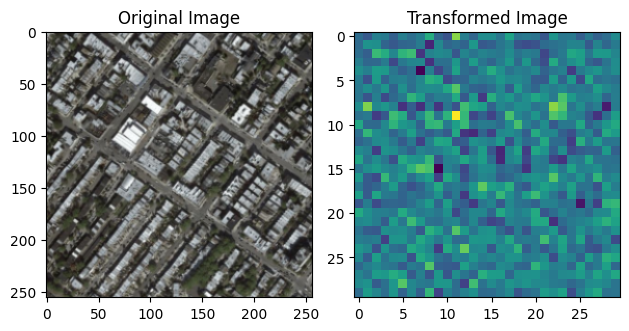

In [134]:
# Create an instance of the Discriminator
test_netD = Discriminator()
test_netD = test_netD.to(device)

# test_netD.eval()


inputs = (img_ori, test_netG_result)
test_netD_result = test_netD(inputs)
print(img_ori.shape, test_netG_result.shape, test_netD_result.shape)
showImgPair((img_ori[0], test_netD_result[0]))

### Summary of Discriminator Model

In [135]:
data = torch.rand((1, 3, 256, 256))
summary(test_netD, input_size=(data.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,144
         LeakyReLU-2         [-1, 64, 128, 128]               0
      EncoderBlock-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         LeakyReLU-6          [-1, 128, 64, 64]               0
      EncoderBlock-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        LeakyReLU-10          [-1, 256, 32, 32]               0
     EncoderBlock-11          [-1, 256, 32, 32]               0
        ZeroPad2d-12          [-1, 256, 34, 34]               0
           Conv2d-13          [-1, 512, 31, 31]       2,097,152
      BatchNorm2d-14          [-1, 512,

### Discriminator Graph Visualization

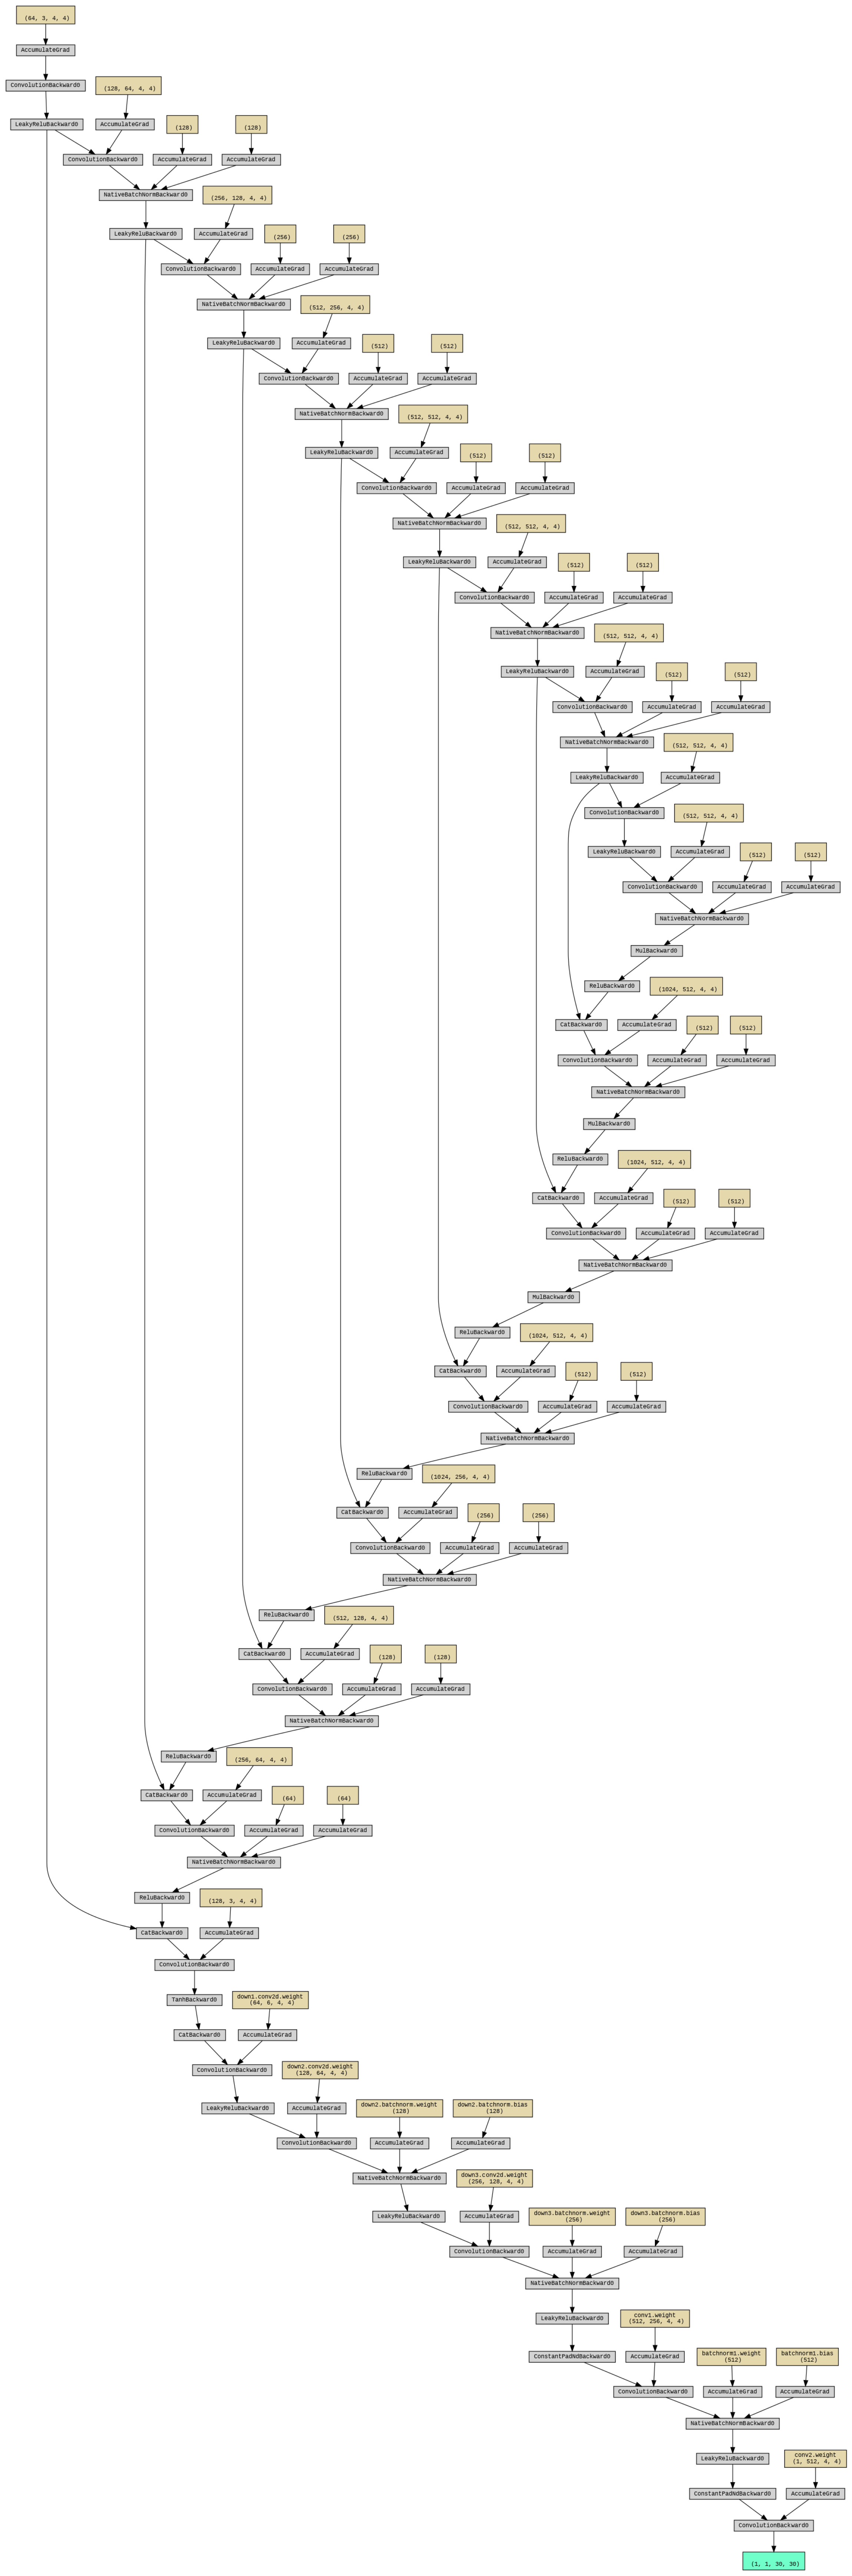

In [136]:
# Create a visualization of the computation graph
dot = make_dot(test_netD_result, params=dict(test_netD.named_parameters()))

# Save the graph as an image or display it
path_test_netD = dot.render("path_test_netD_graph", format="png")
showNetworkGraph(path_test_netD)

### Discriminator loss

It receives two inputs: real images and generated (fake) images
* `real_loss` - sigmoid cross-entropy loss comparing the **real** image and one array of 1's
* `generated_loss (fake)` - sigmoid cross-entropy loss comparing the **generated** image and one array of 0's

The total loss is a sum of both losses

In [137]:
"""
Discriminator Loss Function for Binary Classification

This module defines a custom discriminator loss function for training binary classifiers, often used in adversarial
networks like Generative Adversarial Networks (GANs). The loss function includes two components: a real data loss and
a generated data loss, both using Binary Cross-Entropy loss.

"""


# Define the Binary Cross-Entropy Loss
criterionD = nn.BCEWithLogitsLoss()

def loss_netD(netD_real_output, netD_generated_output):
    """
    Compute the discriminator loss for binary classification.

    Args:
        netD_real_output (torch.Tensor): Discriminator's output for real data.
        netD_generated_output (torch.Tensor): Discriminator's output for generated data.

    Returns:
        torch.Tensor: Total discriminator loss, combining real data loss and generated data loss.

    """
    # Calculate the real data loss (Binary Cross-Entropy)
    ones = torch.ones_like(netD_real_output)
    real_loss = criterionD(ones, netD_real_output)

    # Calculate the generated data loss (Binary Cross-Entropy)
    zeros = torch.zeros_like(netD_generated_output)

    generated_loss = criterionD(zeros, netD_generated_output)



    # Calculate the total discriminator loss by summing real and generated data losses
    d_total_loss = real_loss + generated_loss

    return d_total_loss

# Example usage:
# total_loss = discriminator_loss(real_output, generated_output)


## Generating images

In [138]:
"""
Image Generation and Visualization Function

This function generates and visualizes images using a given model and input. It is typically used for evaluating
image-to-image translation models and displaying the input image, ground truth, and generated output.

"""


def generate_images(model, test_input, real ):
    """
    Generate and visualize images using a model.

    Args:
        model (torch.nn.Module): The image generation model to be evaluated.
        test_input (torch.Tensor): Input data used for image generation.
        real (torch.Tensor): Ground truth or real data for comparison.
        step (int, optional): An optional step or iteration number for saving the visualization.

    Returns:
        None

    """
    generated_img = model(test_input)
    generated_img = generated_img.cpu()
    test_input = test_input.cpu()
    real = real.cpu()

    plt.figure(figsize=(12, 8))

    img_list = [test_input[0].permute(1, 2, 0).detach().numpy(),
                real[0].permute(1, 2, 0).detach().numpy(),
                generated_img[0].permute(1, 2, 0).detach().numpy()
               ]
    title = ['Input image', 'Real (ground truth)', 'Generated image (fake)']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(img_list[i])
        plt.axis('off')



    plt.show()

# Example usage:
# generate_images(model, test_input, real_data, step=1)


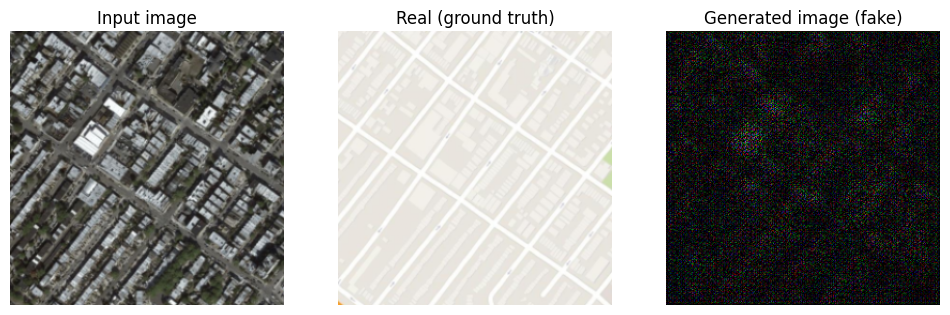

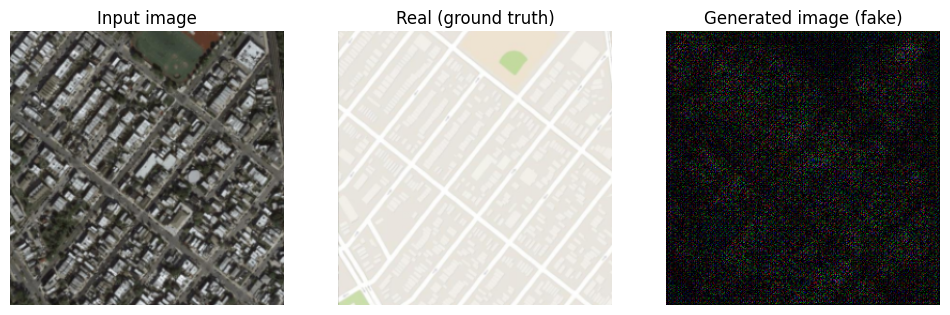

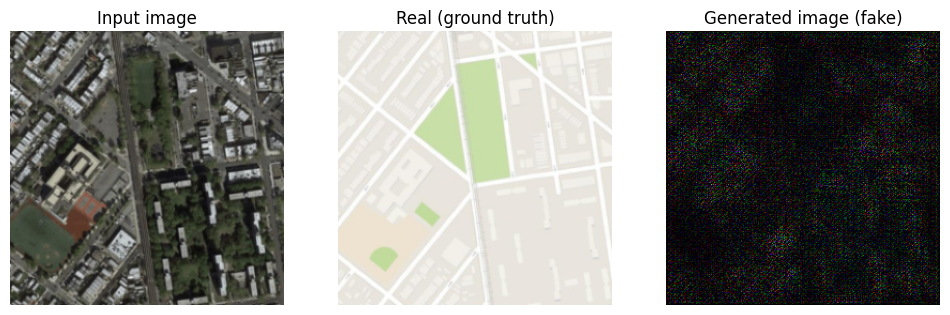

In [139]:
for i, (input_example, real_example) in enumerate(test_loader):
  input_example = input_example.to(device)
  real_example = real_example.to(device)
  generate_images(test_netG, input_example, real_example)

  if i > 1:
    break

## Training

* For each input, an output is generated.
* The discriminator receives input_img and the generated images as the first input. The second input is img_entry and the "real" (expected)
* Then, the loss of the generator and discriminator is calculated
* Then we calculate the loss gradients with respect to the generator and discriminator variables (inputs) and apply these to the optimizer.

### Optimizers and Network Models

In [140]:
import torch.optim as optim

netG = Generator().to(device)
netD = Discriminator().to(device)

# Create Adam optimizers for the generator and discriminator
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))

In [141]:
from torch.utils.tensorboard import SummaryWriter

# Create an instance of SummaryWriter for Tensorboard logging
writer = SummaryWriter()

### Function to generate N images

In [142]:
def generateNImages(n=1):
  netG.eval()
  for i, (input_example, real_example) in enumerate(test_loader):
    input_example = input_example.to(device)
    real_example = real_example.to(device)
    generate_images(netG, input_example, real_example)

    if (i+1)>=n:
      break

### Training Step

In [143]:
def training_step(input_img, real):
    # Enable gradient tracking for both generator and discriminator
    netG.train()
    netD.train()

    #############################
    # Train Discriminator network
    #############################

    # Zero out the gradients in the optimizer's variables
    optimizerD.zero_grad()

    # Forward pass through the generator
    g_output = netG(input_img)

    fake_ab = (input_img, g_output)

    # Forward pass through the discriminator for real and generated images
    d_output_generated = netD(fake_ab)
    d_output_real = netD((input_img, real))

    # Calculate the discriminator loss
    d_loss = loss_netD(d_output_real, d_output_generated)

    d_loss.backward(retain_graph=True)
    optimizerD.step()

    #############################
    # Train Generator network
    ############################

    # Zero out the gradients in the optimizer's variables
    optimizerG.zero_grad()

    fake_ab = (input_img, g_output)

    # Forward pass through the discriminator for generated images
    d_output_generated = netD(fake_ab)

    # Calculate losses
    g_total_loss, g_loss_gan, g_loss_l1 = loss_netG(d_output_generated, g_output, real)

    g_total_loss.backward()

    # Update the generator using its optimizer
    optimizerG.step()

    # print(g_total_loss.item(), g_loss_gan.item(), g_loss_l1.item(), d_loss.item())

    return g_total_loss, g_loss_gan, g_loss_l1, d_loss


### Run Training Epochs

In [144]:
epochs = 30

num_batches = len(train_loader)
print_every = num_batches // 10  # Print a dot every 10% completion

print(print_every, num_batches)

for epoch in range(epochs):
  for i, (input_img, real_img) in enumerate(train_loader):
    if i == 0:
      print(f"\nEpoch [{epoch+1}/{epochs}]", end='', flush=True)

    if (i + 1) % print_every == 0:
      print('.', end='', flush=True)

    # if (i + 1) == num_batches//2:
    #   generateNImages()

    input_img = input_img.to(device)
    real_img = real_img.to(device)

    losses = training_step( input_img, real_img)
    # generateNImages()

  print(f"\t g_total_loss: {losses[0].item():.4f}, g_loss_gan: {losses[1].item():.4f} g_loss_l1: {losses[2].item():.4f}, d_loss: {losses[3].item():.4f}")
  generateNImages()



109 1096

Epoch [1/30]

KeyboardInterrupt: ignored